# Trayendo datos de poloniex y convirtiendolos en dataframe

In [143]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="USDT_ETH",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-03-01 00:00:00"),
                  period=3600*4)
"""
# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
"""
per = 0.85
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
cum_return2 = marketReturn(df[int(len(df)*per):]["close"]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 273.090369795


,close,high,low,open,quoteVolume,volume,weightedAverage,volatility
date,,,,,,,,
2017-07-01 03:00:00,264.536109,275.49704,262.618240,264.262714,10036.43797623,2.709491e+06,269.965394,False
2017-07-01 07:00:00,265.616660,266.11986,255.504261,265.000000,9974.12933202,2.595581e+06,260.231335,False
2017-07-01 11:00:00,247.806687,265.99000,242.780000,265.990000,29561.85752323,7.412609e+06,250.749087,True
2017-07-01 15:00:00,254.500000,258.50000,241.000000,248.000000,17394.24058595,4.338390e+06,249.415337,False
2017-07-01 19:00:00,246.989048,255.00000,242.300000,255.000000,14977.19086764,3.731813e+06,249.166400,True


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

Retorno del mercacdo: 273.090369795
Retorno de SMA13 VS EMA5: 253.52790112
Retorno de Precio VS SMA20: 520.583111069
Retorno de Precio VS EMA5: 1026.49996006


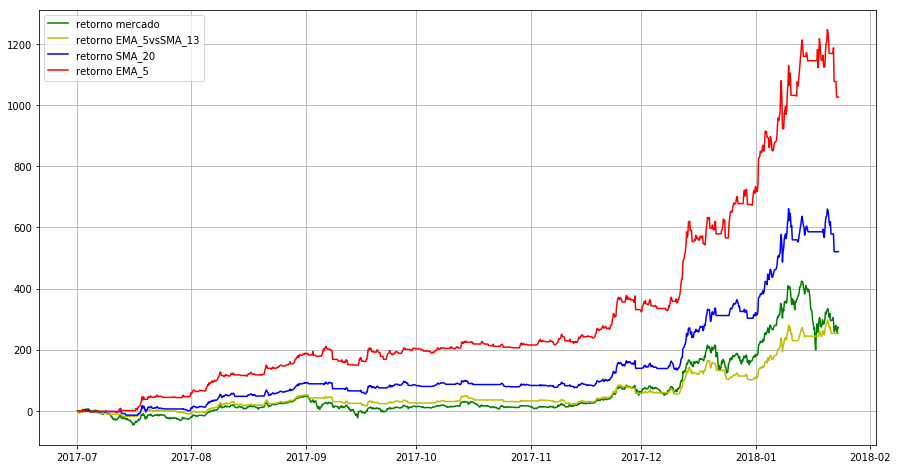

In [144]:
from strategy2 import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()


## RSI via stockstacks

In [145]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

In [146]:
c=20
stock = StockDataFrame.retype(df.copy())
volatile = stock["pdi"]>c

stock["volatile"] = volatile
stock[["pdi","volatile"]].head(30)

,pdi,volatile
date,,
2017-07-01 03:00:00,NaN,False
2017-07-01 07:00:00,0.000000,False
2017-07-01 11:00:00,0.000000,False
2017-07-01 15:00:00,0.000000,False
2017-07-01 19:00:00,0.000000,False
2017-07-01 23:00:00,3.092483,False
2017-07-02 03:00:00,17.095994,False
2017-07-02 07:00:00,14.471510,False
2017-07-02 11:00:00,29.661528,True


In [147]:
from peakdetect import peakdetect

y = df['close'].values
x = df.index[:].values

_max, _min = peakdetect(y, x, 3)

xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]




## Indicadores via TA-Lib

In [148]:
#import talib

#df["fastk"], df["fastd"] = talib.STOCHRSI(df["close"].values, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

#plt.subplot(211)
#plot = plt.plot(x, y)
#plt.hold(True)
#plt.plot(xm, ym, "r+")
#plt.plot(xn, yn, "g+")
#plt.subplot(212)
#df["fastk"].plot()
#df["fastd"].plot()

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

Retorno de estrategia ideal: 59270.3761443


,cci,close,ideal_w,macd,macds,price,price_ema5,price_sma20,pricew,rsi,sma13ema5,volatility,volumen,wr
date,,,,,,,,,,,,,,
2018-01-22 19:00:00,-74.463414,1003.780000,0.0,-22.157033,-13.799039,1003.780000,1.0,0.0,995.604623,44.295418,0.0,False,1.809337e+06,60.103817
2018-01-22 23:00:00,-113.835542,944.100000,0.0,-26.991354,-16.437502,944.100000,0.0,0.0,952.466646,38.475648,0.0,True,2.606920e+06,82.967364
2018-01-23 03:00:00,-123.838616,933.599453,0.0,-31.308984,-19.411798,933.599453,0.0,0.0,938.905714,37.541057,0.0,False,2.579962e+06,85.937067
2018-01-23 07:00:00,-69.225903,988.390000,0.0,-29.964189,-21.522276,988.390000,0.0,0.0,943.555640,45.042439,0.0,True,4.118644e+06,59.963372
2018-01-23 11:00:00,-13.629301,986.958746,1.0,-28.683276,-22.954476,986.958746,1.0,0.0,1006.166858,44.890769,0.0,False,6.049140e+06,60.626673


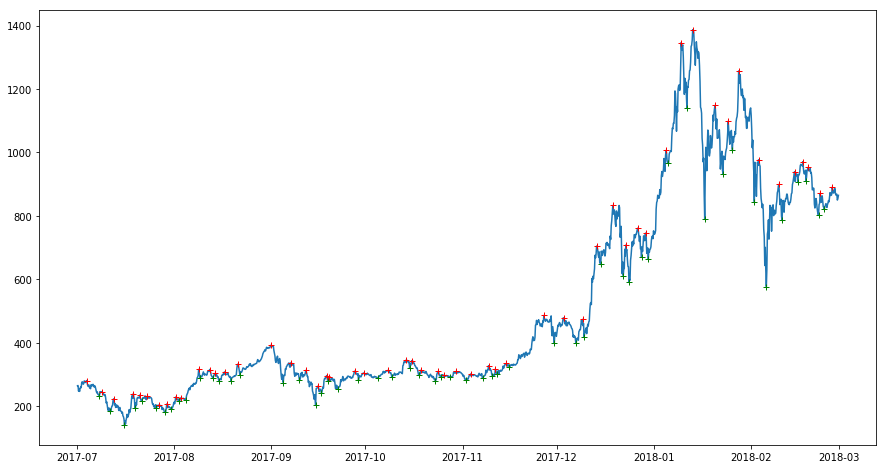

In [149]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"],la=10)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"] ,"sma13ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],
                          "ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"]})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]
#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
train.tail()

# Creando modelo de regresion logistica utilizando sticklearn

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# Estas dos últimas librerías permiten la creación de una 
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
# "price","volumen","rsi","macd","macds","sma13ema5","price_sma20","price_ema5","ideal_w","cci","diff","wr"
features = ["price","rsi","cci","macds","macd"]

# regresion logistica
logreg = LogisticRegression()

train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(method='bfill', inplace=True)
# entrenando modelos
logreg.fit(train[features],train["ideal_w"])

C:\Users\Daniel.LAPTOP-OBVONK0N\Anaconda2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [151]:
# random forests
random_forest = RandomForestClassifier(n_estimators=10)

random_forest.fit(train[features],train["ideal_w"])

#DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=16)

decision_tree.fit(train[features],train["ideal_w"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [152]:
# knn
knn = KNeighborsClassifier(n_neighbors = 30)

knn.fit(train[features],train["ideal_w"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [153]:
# Neural network

# MLPClassifier

mlpc = MLPClassifier(solver='lbfgs',random_state=1, hidden_layer_sizes=(2,100))

mlpc.fit(train[features],train["ideal_w"])

# BernoulliRBM

rbm = BernoulliRBM()
logistic = LogisticRegression()
classifier = Pipeline([("rbm",rbm),("logistic",logistic)])
classifier.fit(train[features],train["ideal_w"])

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=None, verbose=0)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## probando modelo en otros datos

Regresion logistica: 0.762520193861
random forest: 0.994345718901
decision_tree: 0.988691437803
Regresion knn: 0.788368336026
Regresion mlpc: 0.737479806139
Regresion rbm: 0.540387722132
Retorno del mercacdo: -12.2676587782
Retorno de ML_mlpc: 7.69635794513
Retorno de ML_Boltzman: -11.5481469127
Retorno de ML_randfor: 2.63914373401
Retorno de ML_decision_tree: 9.23072261506


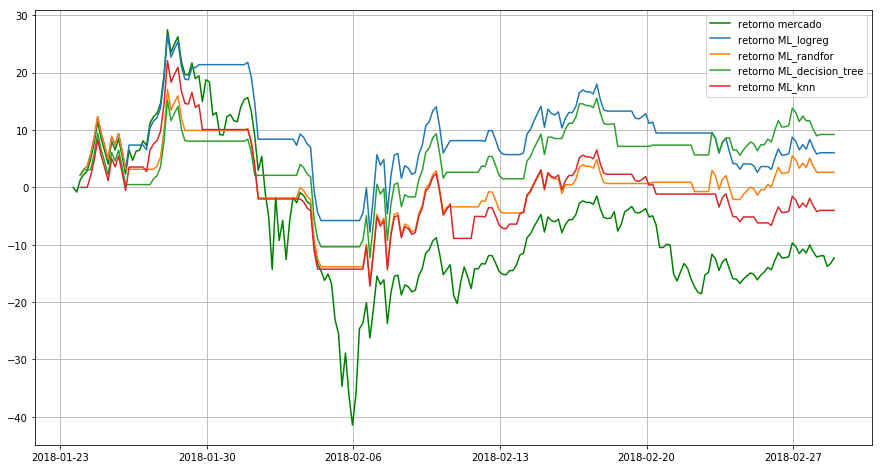

In [154]:
# regresion logistica
w_pred = logreg.predict(test[features])
print "Regresion logistica:",logreg.score(train[features],train["ideal_w"])
#print "Regresion logistica:",logreg.score(test[features],w_pred)

w5 = pd.DataFrame(data={"w":w_pred,"price":test["close"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

# random forest
w_pred2 = random_forest.predict(test[features])
print "random forest:",random_forest.score(train[features],train["ideal_w"])

w6 = pd.DataFrame(data={"w":w_pred2,"price":test["close"]})
w6["orders"] = orders(w6["w"])
w6["w"] = w6["w"].shift(1)
relativeReturn6, v6 = profit(w6)

# decision tree
w_pred22 = decision_tree.predict(test[features])
print "decision_tree:",decision_tree.score(train[features],train["ideal_w"])

w62 = pd.DataFrame(data={"w":w_pred22,"price":test["close"]})
w62["orders"] = orders(w62["w"])
w62["w"] = w62["w"].shift(1)
relativeReturn62, v62 = profit(w62)

# knn
w_pred3 = knn.predict(test[features])
print "Regresion knn:",knn.score(train[features],train["ideal_w"])

w7 = pd.DataFrame(data={"w":w_pred3,"price":test["close"]})
w7["orders"] = orders(w7["w"])
w7["w"] = w7["w"].shift(1)
relativeReturn7, v7 = profit(w7)

# mlpc
w_pred4 = mlpc.predict(test[features])
print "Regresion mlpc:",mlpc.score(train[features],train["ideal_w"])

w8 = pd.DataFrame(data={"w":w_pred4,"price":test["close"]})
w8["orders"] = orders(w8["w"])
w8["w"] = w8["w"].shift(1)
relativeReturn8, v8 = profit(w8)

# rbm
w_pred5 = classifier.predict(test[features])
print "Regresion rbm:",classifier.score(train[features],train["ideal_w"])

w9 = pd.DataFrame(data={"w":w_pred5,"price":test["close"]})
w9["orders"] = orders(w9["w"])
w9["w"] = w9["w"].shift(1)
relativeReturn9, v9 = profit(w9)


print 'Retorno del mercacdo: %s'%(marketReturn2)
"""
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_logreg: %s'%(relativeReturn5*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)
print 'Retorno de ML_knn: %s'%(relativeReturn7*100)
"""
print 'Retorno de ML_mlpc: %s'%(relativeReturn8*100)
print 'Retorno de ML_Boltzman: %s'%(relativeReturn9*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)
print 'Retorno de ML_decision_tree: %s'%(relativeReturn62*100)

plt.plot(df.index[int(len(data)*per):],cum_return2*100,'g', label='retorno mercado')
#plt.plot(df.index[int(len(data)*per):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
#plt.plot(df.index[int(len(data)*per):],v3Test*100,'b',label='retorno SMA_20')
#plt.plot(df.index[int(len(data)*per):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*per):],v5*100,label='retorno ML_logreg')
plt.plot(df.index[int(len(data)*per):],v6*100,label='retorno ML_randfor')
plt.plot(df.index[int(len(data)*per):],v62*100,label='retorno ML_decision_tree')
plt.plot(df.index[int(len(data)*per):],v7*100,label='retorno ML_knn')
#plt.plot(df.index[int(len(data)*per):],v8*100,label='retorno ML_mlcp')
#plt.plot(df.index[int(len(data)*per):],v9*100,label='retorno ML_Botzman')

plt.legend(loc='best')
plt.grid()


In [155]:
w5.tail()

,price,w,orders,return
date,,,,
2018-02-28 07:00:00,868.000000,1.0,WAIT,0.060401
2018-02-28 11:00:00,868.480000,0.0,WAIT,0.060401
2018-02-28 15:00:00,850.000000,0.0,WAIT,0.060401
2018-02-28 19:00:00,855.000000,0.0,WAIT,0.060401
2018-02-28 23:00:00,864.906946,0.0,WAIT,0.060401


In [156]:
from strategy import ml_logreg

# Caracteristicas sobre las que se entrenara el modelo
feature_dic = {"rsi":stock["rsi_14"],"cci":stock["cci"],"price":df["close"]}

# Creando vector de pesos utilizando estrategia de ML de regresión logística
w_logreg = ml_logreg(df["close"],per=0.9,**feature_dic)

# Calculando retorno
relativeReturn6, v6 = profit(w_logreg)

print 'Retorno de ML_strategy: %s'%(relativeReturn6*100)

Retorno de ML_strategy: -4.17552707251


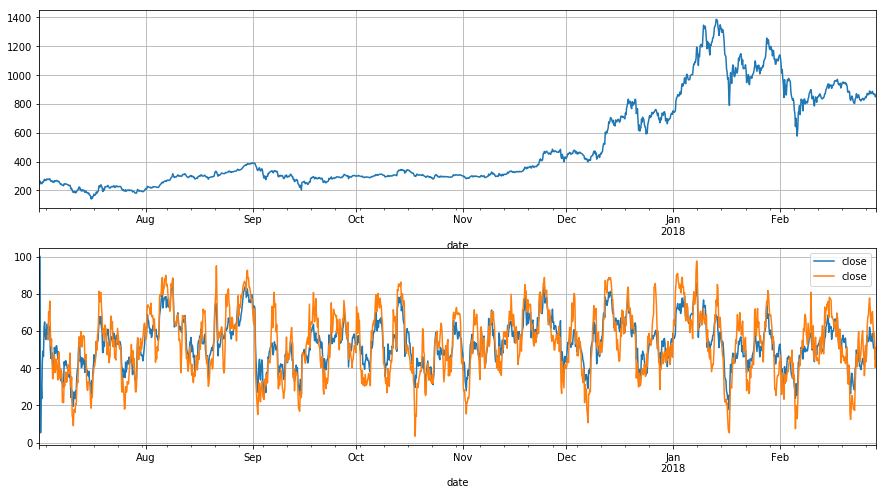

In [157]:
from indicators import rsi

RSI1, RSI2 = rsi(df["close"])

RSI1.head()

plt.subplot(211)
#plt.plot(df.index[1:],df['close'][1:],'r', label='precio')
plt.legend(loc='best')
df["close"].plot()
plt.grid()

plt.subplot(212)
RSI1.plot()
RSI2.plot()
plt.legend(loc='best')
plt.grid()